# Homework 3 - Name, SCIPER

In this homework, we are going to work with the transformer. There are three parts of this homework.

- In the first part, we are going to implement **positional encoding** and **self-attention**  and test them on a simple text dataset which contains around 100 sentences. We will use a small transformer in this task.

- In the second part, we will detect promoters from the DNA sequences. The main difference compared to the previous task is to tokenize the DNA sequence. Thus, our task here is to build the **tokenizer** to tokenize the DNA sequence. For the model, we will continue using the small transformer.

- In the third part, we will use a **foundation model** DNABERT to perform promoter detection. In this part, you do not need to train the transformer. Instead, you need to find and load the correct pre-trained model and then use it to get the embedding of the DNA sequence. Then, you will build a simple classifier to perform promoter detection based on the DNA embedding.



## 0. Initialization

Import the packages you are going to use here.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from transformers import BertConfig, BertModel, AutoTokenizer
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import random
import numpy as np
from torchmetrics.classification import BinaryF1Score

import ipywidgets as widgets
from types import SimpleNamespace
from utils import data, evaluation, models, visualization, text_exercise

import math

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import umap.umap_ as umap
import matplotlib.pyplot as plt


Set the hyperparameters.

In [2]:
# Set seeds
seed = 128
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Some functions to evaluate my models which I use in several places later.

In [3]:
def binary_accuracy(preds, y):
    # Move labels to the same device as predictions
    y = y.to(preds.device)

    # Round predictions to the closest integer (0 or 1)
    rounded_preds = torch.round(preds)
    
    # Compare with the true labels
    correct = (rounded_preds == y).float()
    
    # Average accuracy
    acc = correct.sum() / len(correct)
    return acc

def evaluate_model_accuracy(model, train_loader, test_loader, device):
    model.eval()
    total_train_acc = 0
    total_test_acc = 0

    # Evaluate on training set
    with torch.no_grad():
        for batch in train_loader:
            batch_input_ids, batch_labels = batch
            batch_input_ids, batch_labels = batch_input_ids.to(device), batch_labels.to(device)
            predictions = model(batch_input_ids).squeeze()
            acc = binary_accuracy(predictions, batch_labels)
            total_train_acc += acc.item()

    # Evaluate on test set
    with torch.no_grad():
        for batch in test_loader:
            batch_input_ids, batch_labels = batch
            batch_input_ids, batch_labels = batch_input_ids.to(device), batch_labels.to(device)
            predictions = model(batch_input_ids).squeeze()
            acc = binary_accuracy(predictions, batch_labels)
            total_test_acc += acc.item()

    avg_train_acc = total_train_acc / len(train_loader)
    avg_test_acc = total_test_acc / len(test_loader)
    return avg_train_acc, avg_test_acc

## 1. Positional Encoding and Self-Attention (7 pts)

### 1.1. Sinusoidal Positional Encoding (1 pt)

In this section, you are going to implement the sinusoidal positional encoding. The formula is as the following:

<div>
<img src="./imgs/positional embedding.png" width="400"/>
</div>

where $t$ is the desired position in the input and $\mathsf{\omega}_k$ follows:

<div>
<img src="./imgs/omega.png" width="200"/>
</div>

To see the details of sinusoidal positional encoding, you can check this [link](https://kazemnejad.com/blog/transformer_architecture_positional_encoding/).

In [4]:
import torch
import torch.nn as nn
import math

class PositionalEmbedding(nn.Module):

    def __init__(self, max_position_embeddings, hidden_size, device):
        super().__init__()

        # Create a positional encoding matrix
        position = torch.arange(max_position_embeddings).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, hidden_size, 2).float() * (-math.log(10000.0) / hidden_size))
        positional_embedding = torch.zeros(max_position_embeddings, hidden_size)

        positional_embedding[:, 0::2] = torch.sin(position * div_term)
        positional_embedding[:, 1::2] = torch.cos(position * div_term)
        self.positional_embedding = positional_embedding.to(device)

    def forward(self, x):
        return self.positional_embedding
    
    def embedding(self):
        return self.positional_embedding


Here, you can visualize your positional encoding. If you implement everything correctly, you can get a figure that is similar to Figure 2 in this [link](https://kazemnejad.com/blog/transformer_architecture_positional_encoding/).

In [5]:
visualize_embedding, dimension_selector, max_len_selector = visualization.display_positional_encoding(PositionalEmbedding)
ui = widgets.HBox([max_len_selector, dimension_selector])  
out = widgets.interactive_output( visualize_embedding, {'max_len': max_len_selector, 'dimension': dimension_selector})
display(ui, out)

Output()

### 1.2. Self-Attention Mechanism (5 pts)

In this section, you are going to implement the self-attention mechanism. Please check the section 'Self-Attention in Detail' in this [link](https://jalammar.github.io/illustrated-transformer/) for the details of self-attention mechanism. (We encourage you to carefully go through the link since it is a very good tutorial for transformer.)

The specific steps will be provided in the comments of the following code. (The steps are only for reference. You do need to follow the steps if you have a better way to implement it.)

In [6]:
class BertSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        if config.hidden_size % config.num_attention_heads != 0:
            raise ValueError(
                "The hidden size (%d) is not a multiple of the number of attention "
                "heads (%d)" % (config.hidden_size, config.num_attention_heads)
            )
        self.output_attentions = config.output_attentions
        self.num_attention_heads = config.num_attention_heads
        self.attention_head_size = int(config.hidden_size / config.num_attention_heads)
        self.all_head_size = self.num_attention_heads * self.attention_head_size

        # ToDo: initialize K, Q, V
        self.query = nn.Linear(config.hidden_size, self.all_head_size)
        self.key = nn.Linear(config.hidden_size, self.all_head_size)
        self.value = nn.Linear(config.hidden_size, self.all_head_size)

        # ToDo: add a dropout layer
        # Hint: using config.attention_probs_dropout_prob as the dropout probability
        self.dropout = nn.Dropout(config.attention_probs_dropout_prob)

    def transpose_for_scores(self, x):
        new_x_shape = x.size()[:-1] + (self.num_attention_heads, self.attention_head_size)
        x = x.view(*new_x_shape)
        return x.permute(0, 2, 1, 3)

    def forward(
        self,
        hidden_states,
        attention_mask=None,
        head_mask=None,
        encoder_hidden_states=None,
        encoder_attention_mask=None,
    ):
        # The parameter encoder_hidden_states and encoder_attention_mask is for cross-attention. 
        # We do not use them in this homework.

        # ToDo: get the key, query, and value from the hidden_states
        mixed_query_layer = self.query(hidden_states)
        mixed_key_layer = self.key(hidden_states)
        mixed_value_layer = self.value(hidden_states)

        # ToDo: transpose K, Q, V to get the score
        # Hint: using self.transpose_for_scores
        query_layer = self.transpose_for_scores(mixed_query_layer)
        key_layer = self.transpose_for_scores(mixed_key_layer)
        value_layer = self.transpose_for_scores(mixed_value_layer)

        # ToDo: Get the raw attention score
        # Hint: Lecture 05 transformers - Slide 23 - the part within the softmax
        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)
        
        # You do not need to change this part.
        # Explanation of attention_mask: https://lukesalamone.github.io/posts/what-are-attention-masks/
        if attention_mask is not None:
            attention_scores = attention_scores + attention_mask

        # ToDo: Normalize the attention scores to probabilities.
        # Hint: 
        # 1. Lecture 05 transformers - Slide 23 - using softmax to get the probability
        # 2. Use self.dropout to do the dropout

        attention_probs = nn.Softmax(dim=-1)(attention_scores)
        attention_probs = self.dropout(attention_probs)

        # You do not need to change this part.
        if head_mask is not None:
            attention_probs = attention_probs * head_mask

        # ToDo: Multiply each value by the score
        # Hint: 
        # 1. Lecture 05 transformers - Slide 23 - getting the final result
        # 2. Permuting the result to the correct shape. If you do not know what should be the correct shape, you can print the shape of the tensors.
        context_layer = torch.matmul(attention_probs, value_layer)

        # For a single attention head
        if self.num_attention_heads == 1:
            context_layer = context_layer.squeeze(1)  # Remove the singleton head dimension

        # For multiple attention heads
        else:
            context_layer = context_layer.permute(0, 2, 1, 3).contiguous() # [batch_size, num_attention_heads, sequence_length, attention_head_size]
            new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)
            context_layer = context_layer.view(*new_context_layer_shape)

        # Get the output
        outputs = (context_layer, attention_probs) if self.output_attentions else (context_layer,)
        return outputs

Let's test your implementation using simple text data! First, let's load the data.

We use a small dataset in this homework for a shorter training time.

In [7]:
# ChatGPT generated text data about BERT
text = text_exercise.get()
sentences_df, vocab = data.to_sentence_df(text)

After loading the data, you can train your model. Here we train our model using masked token prediction.

Hint: The final model accuracy should be higher than 0.9.

In [8]:
text_max_len = 11

text_config = SimpleNamespace(
        vocab_size=len(vocab),
        hidden_size=60,
        max_position_embeddings=text_max_len,
        type_vocab_size=1,
        layer_norm_eps=1e-12,
        hidden_dropout_prob=0.0,
        attention_probs_dropout_prob=0.0,
        num_attention_heads=1,
        hidden_act="gelu",
        intermediate_size=160,
        num_hidden_layers=1,
        is_decoder=False,
        output_attentions=True,
        output_hidden_states=False,
        pruned_heads = {},
        initializer_range=0.02,
        device="cpu"
    )

tokenizer = data.TextTokenizer(vocab)
input_ids, segment_ids, masked_lm_labels, labels_idx, labels, attention_masks = data.generate_masked_data(sentences_df, tokenizer, k=1, max_len=text_max_len, noise_rate=0.4)

model = models.BertForMaskedLM(config=text_config, positional_embedding=PositionalEmbedding, attention=BertSelfAttention)
optimizer = optim.AdamW(model.parameters(), lr=0.001)
print(f"Number of trainable model parameters: {models.number_of_model_parameters(model)}")

for epoch in range(200):
    optimizer.zero_grad()
    loss, outputs, attentions = model(
        input_ids=input_ids,
        token_type_ids=segment_ids,
        masked_lm_labels=masked_lm_labels,
        attention_mask=attention_masks
    )
    if (epoch + 1) % 20 == 0:
        print('Epoch:', '%04d' % (epoch + 1), 'loss =', '{:.6f}'.format(loss))
    loss.backward()
    optimizer.step()

print(f"Final model accuracy: {evaluation.masked_label_accuracy(labels, labels_idx, outputs.data)}")

Number of trainable model parameters: 64910
Epoch: 0020 loss = 4.296028
Epoch: 0040 loss = 3.668624
Epoch: 0060 loss = 3.101197
Epoch: 0080 loss = 2.599946
Epoch: 0100 loss = 2.127119
Epoch: 0120 loss = 1.655937
Epoch: 0140 loss = 1.226140
Epoch: 0160 loss = 0.846563
Epoch: 0180 loss = 0.618837
Epoch: 0200 loss = 0.374640
Final model accuracy: 0.9922480620155039


### 1.3. Visualize Attention (1 pt)

Here, you can visualize the self-attention. 

Question: Can you interpret the visualization of the self-attention?

**Write down you answer here (1 pt):**
This visualization shows how different tokens in a sequence attend to each other when a prediction is made by the model.

In the model's attention mechanism, every token in the sequence has a chance to attend at every other token; this is part of what allows transformer models to have such a nuanced understanding of language context and semantic meaning of words within a sentence. The darker the color, the higher the attention weight between those tokens. For example, we can see that the token "can" has a relatively high attention weight with the token "makes", indicating that in this particular head of the first layer, the model is paying a lot of attention to the relationship between these two words.
The reason is why the matrix is asymetrical (attention of "they" on "can" compared with "can" on "they" is not the same) is the positional encoding, which allows the model to learn the semantic and grammatical meaning of words in relation to the others. In reversed order, the words might not be semantically as important anymore as before.

Axes: The x-axis and y-axis both list the tokens that the model is processing. In transformers, every token attends to every other token, including itself.

Tokens: In Sample 64 we have tokens like "they", "can", "read", "[MASK]", "answer", "questions", and "[PAD]". The "[MASK]" token is typically used in models like this one (BERT) during pre-training, where a token is masked and the model learns to predict it. "[PAD]" tokens are used to fill the sequence to a fixed length.

Attention Patterns: It seems that the "[MASK]" token is receiving a good amount of attention when predicting its own value (self-attention), which is typical during the masked language modeling task. There is often also significant attention being paid to other tokens when considering the "[MASK]" token. This suggests that the model is using these context words to try to predict what the "[MASK]" token should be.


In [9]:
visualize_attention, sample_id_selector = visualization.display_attantion(attentions=attentions, input_ids=input_ids, tokenizer=tokenizer)
widgets.interactive(visualize_attention, sample_id=sample_id_selector)

interactive(children=(Dropdown(description='Sample:', options=(5, 8, 11, 13, 18, 24, 26, 29, 31, 35, 37, 38, 6…

### 1.4. Train on small Wikitext Dataset

Here, you can **optionally** test your model on the smallest wikitext dataset. You should get an test accuracy around 0.4 after training 50 epochs.

This part is only for you to test your code. You can choose to run it or not. It takes around 1 hour to train the model for 50 epochs on the smallest wikitext dataset with Google Colab.

In [10]:
#text_exercise.train_wikitext(device, positional_embedding=PositionalEmbedding, attention=BertSelfAttention)

## 2. Promoter detection (7 pts)

In this section, we detect promoter in DNA sequence.

A promoter is a region of DNA upstream of a gene where relevant proteins (such as RNA polymerase and transcription factors) bind to initiate transcription of that gene. Promoter detection is to identify if there are promoter regions in the given DNA sequence. We have covered this in the lecture. (If you are interested in the promoter, you can check this [link](https://www.genome.gov/genetics-glossary/Promoter) for more details.)

Here, we use a transformer and a classifier. The transformer first embeds the DNA sequences into features, and then the classifier detects the promoter based on the features.

The main difference between text and DNA sequence is how to tokenize the sequence. Thus, you need to implement a tokenizer for the DNA sequence.

### 2.1. DNA Tokenizer (1 pts)

Here, you will implement the DNA tokenizer the same as in DNABERT. Please check this [paper](https://academic.oup.com/bioinformatics/article/37/15/2112/6128680) for implementation details. Also, you need to check the data type and shape for both input and output.

In [11]:
class DNATokenizer(data.Tokenizer):
    def __init__(self, k, vocab, unknown="[UNK]"):
        super().__init__(vocab, unknown)

        # self.k is the k of k-mers
        self.k = k

    def _parse_text(self, text):
        
        # ToDo: get the tokens
        output = [text[i:i+self.k] for i in range(len(text) - self.k + 1)] #k-mers
        # TODO check data type and shape for both input and output
        # TODO Add CLS sign
        return output
        

### 2.2. Test BERT on DNA Sequence

In this section, you will train BERT on DNA sequence to learn the embedding of DNA sequence. The code is provided below and you do not need to write anything.

Hint: the final evaluation accuracy should be higher than 0.2.

In [12]:
kmer = 3
mask_length = kmer
VOCAB_3MER = ["[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]", "AAA", "AAT", "AAC", "AAG", "ATA", "ATT", "ATC", "ATG", "ACA", "ACT", "ACC", "ACG", "AGA", "AGT", "AGC", "AGG", "TAA", "TAT", "TAC", "TAG", "TTA", "TTT", "TTC", "TTG", "TCA", "TCT", "TCC", "TCG", "TGA", "TGT", "TGC", "TGG", "CAA", "CAT", "CAC", "CAG", "CTA", "CTT", "CTC", "CTG", "CCA", "CCT", "CCC", "CCG", "CGA", "CGT", "CGC", "CGG", "GAA", "GAT", "GAC", "GAG", "GTA", "GTT", "GTC", "GTG", "GCA", "GCT", "GCC", "GCG", "GGA", "GGT", "GGC", "GGG" ]

raw_training_data = data.load_csv("./data/train.csv")
raw_test_data = data.load_csv("./data/test.csv")

dna_max_len = 298
batch_size = 128
max_dna_mask = 100
dataset_size = 1000
num_layers = 3
num_heads = 6
dna_config = SimpleNamespace(
        vocab_size=len(VOCAB_3MER),
        hidden_size=60,
        max_position_embeddings=dna_max_len,
        type_vocab_size=1,
        layer_norm_eps=1e-12,
        hidden_dropout_prob=0.0,
        attention_probs_dropout_prob=0.0,
        num_attention_heads=num_heads,
        hidden_act="gelu",
        intermediate_size=160,
        num_hidden_layers=num_layers,
        is_decoder=False,
        output_attentions=True,
        output_hidden_states=True,
        pruned_heads = {},
        initializer_range=0.02,
        device=device
    )

tokenizer = DNATokenizer(k=kmer, vocab=VOCAB_3MER)
input_ids, segment_ids, masked_lm_labels, labels_idx, labels, attention_masks = data.generate_masked_data(raw_training_data, tokenizer, max_len=dna_max_len, max_mask=max_dna_mask, k=mask_length, mask_rate=0.05, max_size=dataset_size)
test_input_ids, test_segment_ids, test_masked_lm_labels, test_labels_idx, test_labels, test_attention_masks = data.generate_masked_data(raw_test_data, tokenizer, max_len=dna_max_len, max_mask=max_dna_mask, k=mask_length, mask_rate=0.05, max_size=dataset_size)

model = models.BertForMaskedLM(config=dna_config, positional_embedding=PositionalEmbedding, attention=BertSelfAttention).to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.002)
print(f"Number of trainable model parameters: {models.number_of_model_parameters(model)}")

train_dataset = TensorDataset(input_ids, segment_ids, masked_lm_labels, labels_idx, labels, attention_masks)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(test_input_ids, test_segment_ids, test_masked_lm_labels, test_labels_idx, test_labels, test_attention_masks)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

for epoch in range(50):
  total_train_loss = 0
  model.train()
  for batch_input_ids, batch_segment_ids, batch_masked_lm_labels, _, _, batch_attention_mask in train_loader:
    optimizer.zero_grad()
    loss, outputs, hidden_states, _ = model(
        input_ids=batch_input_ids.to(device),
        token_type_ids=batch_segment_ids.to(device),
        masked_lm_labels=batch_masked_lm_labels.to(device),
        attention_mask=batch_attention_mask.to(device)
    )
    loss.backward()
    optimizer.step()
    total_train_loss += loss.item()
  avg_train_loss = total_train_loss / len(train_loader)

  if (epoch + 1) % 10 == 0:
    model.eval()
    total_eval_loss = 0
    for batch_input_ids, batch_segment_ids, batch_masked_lm_labels, _, _, batch_attention_mask in test_loader:
      with torch.no_grad():
        loss, outputs, hidden_states, _ = model(
          input_ids=batch_input_ids.to(device),
          token_type_ids=batch_segment_ids.to(device),
          masked_lm_labels=batch_masked_lm_labels.to(device),
          attention_mask=batch_attention_mask.to(device)
        )
        if batch_attention_mask.sum() - torch.numel(batch_attention_mask) > 0 :
          print("found patting", batch_attention_mask.sum())
        total_eval_loss += loss.item()
    avg_eval_loss = total_eval_loss / len(test_loader)
    print('Epoch:', '%04d' % (epoch + 1), 'train cost =', '{:.6f}'.format(avg_train_loss), 'eval cost =', '{:.6f}'.format(avg_eval_loss))

average_train_acc, _ = evaluation.model_masked_label_accuracy(model, train_loader, device)
average_test_acc, last_test_attention = evaluation.model_masked_label_accuracy(model, test_loader, device)
print('Train Acc =', '{:.6f}'.format(average_train_acc), 'Eval Acc =', '{:.6f}'.format(average_test_acc))

Number of trainable model parameters: 118869
Epoch: 0010 train cost = 4.017668 eval cost = 4.066978
Epoch: 0020 train cost = 3.854006 eval cost = 3.990574
Epoch: 0030 train cost = 3.247480 eval cost = 3.409230
Epoch: 0040 train cost = 2.916915 eval cost = 3.228085
Epoch: 0050 train cost = 2.419423 eval cost = 2.758377
Train Acc = 0.263742 Eval Acc = 0.181002


### 2.3. Visualize the Attentions (1 pt)

Here, you can visualize the self-attention. 

Question: compare the visualization to Section 1.3, what can you find here? How do you explain it?

**Write down you answer here (1 pt):**
The attention heatmap in the analysis is very sparse, with many weights pretty much zero, as evidenced by the very light colors. In the first layer, there are distinct vertical patterns where relatively much (compared to the other layers) amount of attention is placed on specific words or k-mers. The sparsity becomes more strong in the higher layers or heads, but now with a noticeable focus around the central diagonal. Most of the attention is diagonal, suggesting that each token primarily attends to itself or its direct neighbors. This displays the significance of neighbour nucleotides in in DNA sequencing where adjacent nucleotides often hold biological importance. In the multi-head attention mechanism, there's a clear variation in the attention patterns across different heads, as each head is learning different types of data relationships which can be seen when switching heads in the diagram.

In [13]:
visualize_attention, sample_id_selector, layer_selector, head_selector = visualization.display_multi_attantion(attentions=last_test_attention, tokenizer=tokenizer, input_ids=input_ids,  layers=range(1, num_layers+1),  heads=range(1, num_heads+1))
ui = widgets.HBox([sample_id_selector, layer_selector, head_selector])  
out = widgets.interactive_output(visualize_attention, {'sample_id': sample_id_selector, 'layer': layer_selector, 'head': head_selector})
display(ui, out)

Output()

### 2.4. Use your pretrained model for promoter detection (5 pts)

You already have the embeddings for the DNA sequence. Now, you are going to build a classifier based on the DNA embeddings. The classifier is to perform promoter detection. Specifically, the DNA sequence will be classified into *'contains promoter'* or *'does not contain promoter'*.

Hint: 
- We now want to annotate data (get the label for each sample), not predict masked data anymore!
- You can reuse some parts of the code in the previous sections, e.g. dataloader and training pipeline in Section 2.2.
- If you implement the previous section correctly (the Eval Acc > 0.2 in Section 2.2), you already have an pre-trained object named 'model' of class models.BertForMaskedLM. You can directly use it.
- The evaluation accuracy of this task should be around 0.6.

In [14]:
def binary_accuracy(preds, y):
    # Move labels to the same device as predictions
    y = y.to(preds.device)

    # Round predictions to the closest integer (0 or 1)
    rounded_preds = torch.round(preds)
    
    # Compare with the true labels
    correct = (rounded_preds == y).float()
    
    # Average accuracy
    acc = correct.sum() / len(correct)
    return acc

def evaluate_model_accuracy(model, train_loader, test_loader, device):
    model.eval()
    total_train_acc = 0
    total_test_acc = 0

    # Evaluate on training set
    with torch.no_grad():
        for batch in train_loader:
            batch_input_ids, batch_labels = batch
            batch_input_ids, batch_labels = batch_input_ids.to(device), batch_labels.to(device)
            predictions = model(batch_input_ids).squeeze()
            acc = binary_accuracy(predictions, batch_labels)
            total_train_acc += acc.item()

    # Evaluate on test set
    with torch.no_grad():
        for batch in test_loader:
            batch_input_ids, batch_labels = batch
            batch_input_ids, batch_labels = batch_input_ids.to(device), batch_labels.to(device)
            predictions = model(batch_input_ids).squeeze()
            acc = binary_accuracy(predictions, batch_labels)
            total_test_acc += acc.item()

    avg_train_acc = total_train_acc / len(train_loader)
    avg_test_acc = total_test_acc / len(test_loader)
    return avg_train_acc, avg_test_acc

In [15]:
# ToDo: Define the classifier
# Hint: We need only a binary classifier.
class BinaryClassifier(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.fc = nn.Linear(in_features, 1)

    def forward(self, x):
        x = torch.sigmoid(self.fc(x))
        return x
    
class CombinedModel(nn.Module):
    def __init__(self, encoder, classifier):
        super(CombinedModel, self).__init__()
        self.encoder = encoder
        self.classifier = classifier

    def forward(self, input_ids):
        # Assuming the first token's representation is used for classification
        encoded_layers = self.encoder(input_ids)[0]
        cls_representation = encoded_layers[:, 0, :]  # Extract the [CLS] representations
        x = self.classifier(cls_representation)
        return x
        
# ToDo: Freeze BERT parameters
# Hint: 
# 1. BERT is the 'model' you have trained in Section 2.2.
# 2. Check Exercise 1 to see how to freeze a model (set requires_grad to False)
for param in model.parameters():
    param.requires_grad = False

# Define model
hidden_size = 60
classifier = BinaryClassifier(hidden_size).to(device)
model_n = CombinedModel(model.bert, classifier).to(device)

# ToDo: Train your classifier
# Hint: 
# 1. Write the training pipeline (dataloader, optimizer, training loop ...)
# 2. You can reuse the code from Section 2.2.

# Prepare and load data (without data mask)
kmer = 3
VOCAB_3MER = ["[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]", "AAA", "AAT", "AAC", "AAG", "ATA", "ATT", "ATC", "ATG", "ACA", "ACT", "ACC", "ACG", "AGA", "AGT", "AGC", "AGG", "TAA", "TAT", "TAC", "TAG", "TTA", "TTT", "TTC", "TTG", "TCA", "TCT", "TCC", "TCG", "TGA", "TGT", "TGC", "TGG", "CAA", "CAT", "CAC", "CAG", "CTA", "CTT", "CTC", "CTG", "CCA", "CCT", "CCC", "CCG", "CGA", "CGT", "CGC", "CGG", "GAA", "GAT", "GAC", "GAG", "GTA", "GTT", "GTC", "GTG", "GCA", "GCT", "GCC", "GCG", "GGA", "GGT", "GGC", "GGG" ]

raw_training_data = data.load_csv("./data/train.csv")
raw_test_data = data.load_csv("./data/test.csv")

dna_max_len = 298
batch_size = 128
dataset_size = 1000

tokenizer = DNATokenizer(k=kmer, vocab=VOCAB_3MER)
input_ids, labels = data.generate_labeled_data(raw_training_data, tokenizer, max_len=dna_max_len, max_size=dataset_size)
test_input_ids, test_labels = data.generate_labeled_data(raw_test_data, tokenizer, max_len=dna_max_len, max_size=dataset_size)

train_dataset = TensorDataset(input_ids, labels.float())
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = TensorDataset(test_input_ids, test_labels.float())
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(classifier.parameters(), lr=0.003)  # Only optimize classifier parameters
print(f"Number of trainable model parameters: {models.number_of_model_parameters(model_n)}")

# Training Loop
for epoch in range(50):
  # Train
  total_train_loss = 0
  total_train_acc = 0
  model_n.train()
  for batch_input_ids, batch_labels in train_loader:
    optimizer.zero_grad()
    predictions = model_n(
        batch_input_ids.to(device),
    ).squeeze()
    loss = criterion(predictions, batch_labels.to(device))
    loss.backward()
    optimizer.step()
    acc = binary_accuracy(predictions, batch_labels)
    total_train_loss += loss.item()
    total_train_acc += acc.item()

  avg_train_loss = total_train_loss / len(train_loader)
  avg_train_acc = total_train_acc / len(train_loader)

  # Evaluate
  if (epoch + 1) % 10 == 0:
    model_n.eval()
    total_eval_loss = 0
    total_eval_acc = 0
    for batch_input_ids, batch_labels in test_loader:
      with torch.no_grad():
        predictions = model_n(
          batch_input_ids.to(device),
        ).squeeze()
        loss = criterion(predictions, batch_labels.to(device))
        acc = binary_accuracy(predictions, batch_labels)
        total_eval_loss += loss.item()
        total_eval_acc += acc.item()
    avg_eval_loss = total_eval_loss / len(test_loader)
    avg_eval_acc = total_eval_acc / len(test_loader)
    print('Epoch:', '%04d' % (epoch + 1), 'train cost =', '{:.6f}'.format(avg_train_loss), 'eval cost =', '{:.6f}'.format(avg_eval_loss), 'train acc =', '{:.6f}'.format(avg_train_acc), 'eval acc =', '{:.6f}'.format(avg_eval_acc))

# Calculate final accuracies on train and test sets
final_train_accuracy, final_test_accuracy = evaluate_model_accuracy(model_n, train_loader, test_loader, device)
print(f'Final Train Accuracy: {final_train_accuracy:.6f}')
print(f'Final Test Accuracy: {final_test_accuracy:.6f}')

Number of trainable model parameters: 110941
Epoch: 0010 train cost = 0.677429 eval cost = 0.704356 train acc = 0.546274 eval acc = 0.499700
Epoch: 0020 train cost = 0.672814 eval cost = 0.707150 train acc = 0.569862 eval acc = 0.496995
Epoch: 0030 train cost = 0.668362 eval cost = 0.707755 train acc = 0.582933 eval acc = 0.501653
Epoch: 0040 train cost = 0.666807 eval cost = 0.710463 train acc = 0.572791 eval acc = 0.506535
Epoch: 0050 train cost = 0.664923 eval cost = 0.708230 train acc = 0.602239 eval acc = 0.505559
Final Train Accuracy: 0.604492
Final Test Accuracy: 0.505559


### 2.5. Additional question (1 pt)

Now we change mask_length = 1 (already changed, you do not need to implement anything).
Let's run the code below and check the accuracy.

Question: What is the final masked token prediction accuracy? How do you explain this?

**Write down you answer here (1 pt):**
(I unfortunately always got a "CUDA out of memory" error on this task on my local machine, but I could see the results from friends, so here is my interpretation anyway)

One could observe a very very high accuracy compared to the task 2.2.
The big difference of this 2.5 to the 2.2 is that the mask_length = 1 for 2.5. This effectively reduces the mask length such that the masked token kann be deduced far more easily from its' neighboring tokens, because it is contained there as a split. Example: Tokens "ABC", "BCD", "CDE". For mask_length = 1 "BCD" might be hidden, but then "ABC" and "CDE" will stay unmasked. "BCD" is now already contained within the latter part of "ABC" and "CDE", while for mask_length = 3 all tokens would be hidden and the deduction would not be so easy. Even though the model obviously paremeterizes the tokens and predicts the masked token in a different way than we humans do, this example still shows source for the difference in difficulty.

In [16]:
kmer = 3
mask_length = 1

dna_max_len = 298
batch_size = 128
max_dna_mask = 100
dataset_size = 1000
num_layers = 3
num_heads = 6
dna_config = SimpleNamespace(
        vocab_size=len(VOCAB_3MER),
        hidden_size=60,
        max_position_embeddings=dna_max_len,
        type_vocab_size=1,
        layer_norm_eps=1e-12,
        hidden_dropout_prob=0.0,
        attention_probs_dropout_prob=0.0,
        num_attention_heads=num_heads,
        hidden_act="gelu",
        intermediate_size=160,
        num_hidden_layers=num_layers,
        is_decoder=False,
        output_attentions=True,
        output_hidden_states=True,
        pruned_heads = {},
        initializer_range=0.02,
        device=device
    )

tokenizer = DNATokenizer(k=3, vocab=VOCAB_3MER)
input_ids, segment_ids, masked_lm_labels, labels_idx, labels, attention_masks = data.generate_masked_data(raw_training_data, tokenizer, max_len=dna_max_len, max_mask=max_dna_mask, k=mask_length, mask_rate=0.05, max_size=dataset_size)
test_input_ids, test_segment_ids, test_masked_lm_labels, test_labels_idx, test_labels, test_attention_masks = data.generate_masked_data(raw_test_data, tokenizer, max_len=dna_max_len, max_mask=max_dna_mask, k=mask_length, mask_rate=0.05, max_size=dataset_size)

model = models.BertForMaskedLM(config=dna_config, positional_embedding=PositionalEmbedding, attention=BertSelfAttention).to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.002)
print(f"Number of trainable model parameters: {models.number_of_model_parameters(model)}")

train_dataset = TensorDataset(input_ids, segment_ids, masked_lm_labels, labels_idx, labels, attention_masks)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(test_input_ids, test_segment_ids, test_masked_lm_labels, test_labels_idx, test_labels, test_attention_masks)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

for epoch in range(50):
  total_train_loss = 0
  model.train()
  for batch_input_ids, batch_segment_ids, batch_masked_lm_labels, _, _, batch_attention_mask in train_loader:
    optimizer.zero_grad()
    loss, outputs, hidden_states, _ = model(
        input_ids=batch_input_ids.to(device),
        token_type_ids=batch_segment_ids.to(device),
        masked_lm_labels=batch_masked_lm_labels.to(device),
        attention_mask=batch_attention_mask.to(device)
    )
    loss.backward()
    optimizer.step()
    total_train_loss += loss.item()
  avg_train_loss = total_train_loss / len(train_loader)

  if (epoch + 1) % 10 == 0:
    model.eval()
    total_eval_loss = 0
    for batch_input_ids, batch_segment_ids, batch_masked_lm_labels, _, _, batch_attention_mask in test_loader:
      with torch.no_grad():
        loss, outputs, hidden_states, _ = model(
          input_ids=batch_input_ids.to(device),
          token_type_ids=batch_segment_ids.to(device),
          masked_lm_labels=batch_masked_lm_labels.to(device),
          attention_mask=batch_attention_mask.to(device)
        )
        if batch_attention_mask.sum() - torch.numel(batch_attention_mask) > 0 :
          print("found patting", batch_attention_mask.sum())
        total_eval_loss += loss.item()
    avg_eval_loss = total_eval_loss / len(test_loader)
    print('Epoch:', '%04d' % (epoch + 1), 'train cost =', '{:.6f}'.format(avg_train_loss), 'eval cost =', '{:.6f}'.format(avg_eval_loss))

average_train_acc, _ = evaluation.model_masked_label_accuracy(model, train_loader, device)
average_test_acc, last_test_attention = evaluation.model_masked_label_accuracy(model, test_loader, device)
print('Train Acc =', '{:.6f}'.format(average_train_acc), 'Eval Acc =', '{:.6f}'.format(average_test_acc))

Number of trainable model parameters: 118869


RuntimeError: CUDA out of memory. Tried to allocate 262.00 MiB (GPU 0; 4.00 GiB total capacity; 2.19 GiB already allocated; 0 bytes free; 2.92 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

## 3. Using foundation model (5 pts)

### 3.1. Introduction

In this section, we aim to use a foundation model, DNABERT, to perform promoter detection.
A foundation model is a model pretrained on large datasets. Foundation models serve as the foundational building blocks upon which various applications can be constructed.

Here, we use DNABERT as the foundation model. We first apply it on DNA sequence to get the embedding. Then, we train a classifier on the embedding as in Section 2. Please follow this [link](https://github.com/Zhihan1996/DNABERT_2) to load the foundation model.

### 3.2. Implementation

**Consider this situation:** You get a dataset about promoter detection, and you build your model to perform the task as in Section 2. However, the performance is not good since the model is not strong enough. Suddenly, you think we can use a large pre-trained model to embed DNA sequences. Then, you search online and find the pre-trained model [DNABERT](https://github.com/Zhihan1996/DNABERT_2). Now, you want to perform promoter detection using the pre-trained DNABERT.

There is no coding framework in this section. Just make things work (get good test accuracy) using the pre-trained model!

Hint: 
- We encourage you to create a **new environment** following the instructions of Section 3 in this [link](https://github.com/Zhihan1996/DNABERT_2). (When you face the error "The model class you are passing has a config_class attribute that is not consistent with the config class you passed ...", creating a new environment can save you.)
- Section 4 in this [link](https://github.com/Zhihan1996/DNABERT_2) shows you how to load and use the pre-trained foundation model.

a. Load the dataset.

In [17]:
# ToDo: Load the train and test datasets from train.csv and test.csv
# Hint: check Section 2.2.

raw_training_data = data.load_csv("./data/train.csv") #def load_csv(filepath): return pd.read_csv(filepath)
raw_test_data = data.load_csv("./data/test.csv")

b. Get the embeddings of the DNA sequences using pretrained model.

Hint: 
- This step can take some time. Thus, you can start with a small sample size, and then increase it when you have made sure that everything works correctly.
- After getting the embeddings, you can save them so that you can directly load them next time without running the foundation model.

In [18]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = AutoTokenizer.from_pretrained("zhihan1996/DNABERT-2-117M", trust_remote_code=True)
config = BertConfig.from_pretrained("zhihan1996/DNABERT-2-117M", trust_remote_code=True)
model = BertModel.from_pretrained("zhihan1996/DNABERT-2-117M", config=config, trust_remote_code=True).to(device)


The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.
The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.
Some weights of BertModel were not initialized from the model checkpoint at zhihan1996/DNABERT-2-117M and are newly initialized: ['bert.encoder.layer.1.attention.self.value.bias', 'bert.encoder.layer.7.attention.self.key.bias', 'bert.encoder.layer.7.attention.self.query.bias', 'bert.encoder.layer.9.output.dense.bias', 'bert.encoder.layer.6.attention.self.key.weight', 'bert.encoder.layer.4.output.LayerNorm.weight', 'bert.encoder.layer.8.output.LayerNorm.weight', 'bert.encoder.layer.11.output.dense.weight', 'bert.encoder.layer.9.output.LayerNorm.weight', 'bert.encoder.layer.3.attention.self.query.bias', 'bert.encoder.layer.4.intermediate.dense.weight', 'bert.encoder.layer.4.attention.self.query.bias', 'bert.encoder.layer.4.attention.self.value.bias', 'bert.encoder.layer.11.attention.

I only calculated the embedding once and stored it in a csv as it as a very intense task. That is why the code below is commented out. If you want to test the notebook, please uncomment the code cells below.

In [ ]:
# # ToDo: Load the pretrained DNABERT model and use this to get the embeddings of the train and test DNA sequences.
# # Hint: Check section Quick Start on https://github.com/Zhihan1996/DNABERT_2

# batch_size = 128

# # Set device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Function to calculate embeddings
# def calculate_embeddings(dataframe):
#     model.eval()  # Set the model to evaluation mode
#     embeddings_mean = []
#     embeddings_max = []
#     all_labels = []

#     # Tokenize the sequences and convert labels to tensor
#     inputs = tokenizer(dataframe['sequence'].tolist(), padding=True, truncation=True, return_tensors='pt') #padding=True, truncation=True,
#     labels = torch.tensor(dataframe['label'].tolist())

#     # DataLoader for batch processing
#     dataset = TensorDataset(inputs['input_ids'], labels)
#     data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

#     for inputs, labels in data_loader:
#         #print(f'Shape inputs: {inputs.shape}')
#         #print(f'Shape labels: {labels.shape}')
#         with torch.no_grad():
#             output = model(inputs.to(device))[0]

#         #print(f'Model output shape: {output.shape}')
#         hidden_states = output
#         #print(f'Hidden states shape: {hidden_states.shape}')

#         # Mean pooling
#         mean_pooling = torch.mean(hidden_states, dim=1)
#         embeddings_mean.append(mean_pooling)

#         # Max pooling
#         max_pooling = torch.max(hidden_states, dim=1)[0]
#         embeddings_max.append(max_pooling)

#         # Collect labels
#         all_labels.append(labels)

#     # Concatenate all batches
#     embeddings_mean = torch.cat(embeddings_mean, dim=0)
#     embeddings_max = torch.cat(embeddings_max, dim=0)
#     all_labels = torch.cat(all_labels, dim=0)

#     return embeddings_mean, embeddings_max, all_labels

# # Get embeddings and labels
# train_embeddings_mean, train_embeddings_max, train_labels = calculate_embeddings(raw_training_data)
# test_embeddings_mean, test_embeddings_max, test_labels = calculate_embeddings(raw_test_data)

# # Convert to DataFrames
# df_train_embeddings_mean = pd.DataFrame(train_embeddings_mean.cpu().numpy())
# df_train_embeddings_max = pd.DataFrame(train_embeddings_max.cpu().numpy())
# df_test_embeddings_mean = pd.DataFrame(test_embeddings_mean.cpu().numpy())
# df_test_embeddings_max = pd.DataFrame(test_embeddings_max.cpu().numpy())

# # Add labels as a column
# df_train_embeddings_mean['label'] = train_labels.numpy()
# df_train_embeddings_max['label'] = train_labels.numpy()
# df_test_embeddings_mean['label'] = test_labels.numpy()
# df_test_embeddings_max['label'] = test_labels.numpy()

# # Save to CSV
# df_train_embeddings_mean.to_csv('./data/train_embeddings_mean.csv', index=False)
# df_train_embeddings_max.to_csv('./data/train_embeddings_max.csv', index=False)
# df_test_embeddings_mean.to_csv('./data/test_embeddings_mean.csv', index=False)
# df_test_embeddings_max.to_csv('./data/test_embeddings_max.csv', index=False)



Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


The code to calculate and store the tsne and umap embedding are commented out as it takes extremely long. I calculated it once, stored it in a csv and loaded it from there in the following runs.

In [ ]:
# ToDo: Using tsne or umap to visualize the embedding space.
# Hint: you can import other packages here for visualization.

# df_train_embeddings_mean = pd.read_csv('./data/train_embeddings_mean.csv')
# df_train_embeddings_max = pd.read_csv('./data/train_embeddings_max.csv')

# # t-SNE
# tsne_mean = TSNE(n_components=2, random_state=42).fit_transform(df_train_embeddings_mean.iloc[:, :-1])
# tsne_max = TSNE(n_components=2, random_state=42).fit_transform(df_train_embeddings_max.iloc[:, :-1])

# # UMAP (as an alternative to t-SNE)
# umap_mean = umap.UMAP(n_components=2, random_state=42).fit_transform(df_train_embeddings_mean.iloc[:, :-1])
# umap_max = umap.UMAP(n_components=2, random_state=42).fit_transform(df_train_embeddings_max.iloc[:, :-1])



c:\Users\timba\.conda\envs\i2dl\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


helo


c:\Users\timba\.conda\envs\i2dl\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [ ]:
# # Save embeddings in CSV.

# # Convert t-SNE embeddings to DataFrame
# df_tsne_mean = pd.DataFrame(tsne_mean, columns=['tsne_mean_dim1', 'tsne_mean_dim2'])
# df_tsne_max = pd.DataFrame(tsne_max, columns=['tsne_max_dim1', 'tsne_max_dim2'])

# # Add labels to t-SNE DataFrames
# df_tsne_mean['label'] = df_train_embeddings_mean['label']
# df_tsne_max['label'] = df_train_embeddings_max['label']

# # Save t-SNE DataFrames to CSV
# df_tsne_mean.to_csv('tsne_mean_embeddings.csv', index=False)
# df_tsne_max.to_csv('tsne_max_embeddings.csv', index=False)

# # Convert UMAP embeddings to DataFrame
# df_umap_mean = pd.DataFrame(umap_mean, columns=['umap_mean_dim1', 'umap_mean_dim2'])
# df_umap_max = pd.DataFrame(umap_max, columns=['umap_max_dim1', 'umap_max_dim2'])

# # Add labels to UMAP DataFrames
# df_umap_mean['label'] = df_train_embeddings_mean['label']
# df_umap_max['label'] = df_train_embeddings_max['label']

# # Save UMAP DataFrames to CSV
# df_umap_mean.to_csv('umap_mean_embeddings.csv', index=False)
# df_umap_max.to_csv('umap_max_embeddings.csv', index=False)


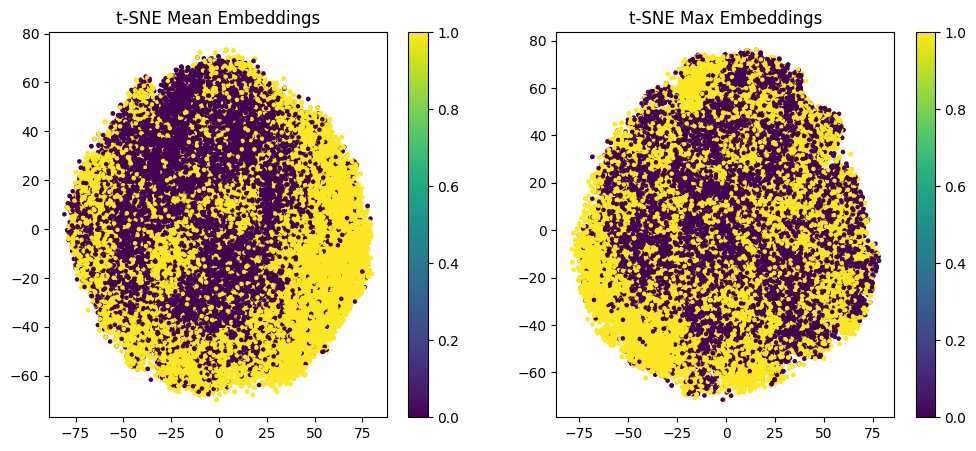

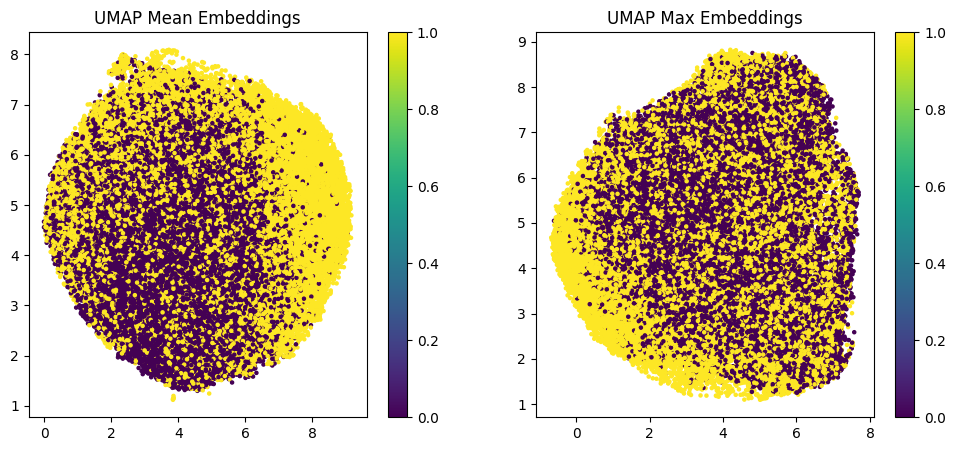

In [ ]:
# Read the saved CSV files
df_tsne_mean = pd.read_csv('tsne_mean_embeddings.csv')
df_tsne_max = pd.read_csv('tsne_max_embeddings.csv')
df_umap_mean = pd.read_csv('umap_mean_embeddings.csv')
df_umap_max = pd.read_csv('umap_max_embeddings.csv')

# Function to plot embeddings
def plot_embeddings(embeddings, labels, title):
    plt.scatter(embeddings[:, 0], embeddings[:, 1], c=labels, cmap='viridis', s=5)
    plt.colorbar()
    plt.title(title)

# Create subplots for t-SNE embeddings
plt.figure(figsize=(12, 5))

# t-SNE Mean Embeddings
plt.subplot(1, 2, 1)
tsne_mean_embeddings = df_tsne_mean[['tsne_mean_dim1', 'tsne_mean_dim2']].values
plot_embeddings(tsne_mean_embeddings, df_tsne_mean['label'], 't-SNE Mean Embeddings')

# t-SNE Max Embeddings
plt.subplot(1, 2, 2)
tsne_max_embeddings = df_tsne_max[['tsne_max_dim1', 'tsne_max_dim2']].values
plot_embeddings(tsne_max_embeddings, df_tsne_max['label'], 't-SNE Max Embeddings')

plt.show()

# Create subplots for UMAP embeddings
plt.figure(figsize=(12, 5))

# UMAP Mean Embeddings
plt.subplot(1, 2, 1)
umap_mean_embeddings = df_umap_mean[['umap_mean_dim1', 'umap_mean_dim2']].values
plot_embeddings(umap_mean_embeddings, df_umap_mean['label'], 'UMAP Mean Embeddings')

# UMAP Max Embeddings
plt.subplot(1, 2, 2)
umap_max_embeddings = df_umap_max[['umap_max_dim1', 'umap_max_dim2']].values
plot_embeddings(umap_max_embeddings, df_umap_max['label'], 'UMAP Max Embeddings')

plt.show()


c. Train a classifier.

Hint: It is easy to overfit on the training set. Try to avoid overfitting.

I kept my model complexity low to prevent overfitting

In [19]:
# ToDo: Define your classifier
class SimpleClassifier(nn.Module):
    def __init__(self, input_dim):
        super(SimpleClassifier, self).__init__()
        self.fc = nn.Linear(input_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc(x)
        x = self.sigmoid(x)
        return x



In [20]:
# ToDo: Train your classifier
batch_size = 32
epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Device: {device}')

# Load embeddings
train_embeddings_mean = pd.read_csv('./data/train_embeddings_mean.csv')
test_embeddings_mean = pd.read_csv('./data/test_embeddings_mean.csv')

# Prepare datasets
X_train = torch.tensor(train_embeddings_mean.iloc[:, :-1].values, dtype=torch.float32)
y_train = torch.tensor(train_embeddings_mean.iloc[:, -1].values, dtype=torch.float32)
X_test = torch.tensor(test_embeddings_mean.iloc[:, :-1].values, dtype=torch.float32)
y_test = torch.tensor(test_embeddings_mean.iloc[:, -1].values, dtype=torch.float32)

# Create TensorDatasets and DataLoaders
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define loss function and optimizer
model_n = SimpleClassifier(input_dim=X_train.shape[1]).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model_n.parameters(), lr=0.001)
print(f"Number of trainable model parameters: {models.number_of_model_parameters(model_n)}")

# Training Loop
for epoch in range(epochs):
  # Train
  total_train_loss = 0
  total_train_acc = 0
  model_n.train()
  for batch_input_ids, batch_labels in train_loader:
    optimizer.zero_grad()
    predictions = model_n(
        batch_input_ids.to(device),
    ).squeeze()
    loss = criterion(predictions, batch_labels.to(device))
    loss.backward()
    optimizer.step()
    acc = binary_accuracy(predictions, batch_labels)
    total_train_loss += loss.item()
    total_train_acc += acc.item()

  avg_train_loss = total_train_loss / len(train_loader)
  avg_train_acc = total_train_acc / len(train_loader)

  # Evaluate
  if (epoch + 1) % 10 == 0:
    model_n.eval()
    total_eval_loss = 0
    total_eval_acc = 0
    for batch_input_ids, batch_labels in test_loader:
      with torch.no_grad():
        predictions = model_n(
          batch_input_ids.to(device),
        ).squeeze()
        loss = criterion(predictions, batch_labels.to(device))
        acc = binary_accuracy(predictions, batch_labels)
        total_eval_loss += loss.item()
        total_eval_acc += acc.item()
    avg_eval_loss = total_eval_loss / len(test_loader)
    avg_eval_acc = total_eval_acc / len(test_loader)
    print('Epoch:', '%04d' % (epoch + 1), 'train cost =', '{:.6f}'.format(avg_train_loss), 'eval cost =', '{:.6f}'.format(avg_eval_loss), 'train acc =', '{:.6f}'.format(avg_train_acc), 'eval acc =', '{:.6f}'.format(avg_eval_acc))

# Calculate final accuracies on train and test sets
final_train_accuracy, final_test_accuracy = evaluate_model_accuracy(model_n, train_loader, test_loader, device)
print(f'Final Train Accuracy: {final_train_accuracy:.6f}')
print(f'Final Test Accuracy: {final_test_accuracy:.6f}')

Device: cuda
Number of trainable model parameters: 769
Epoch: 0010 train cost = 0.477171 eval cost = 0.489519 train acc = 0.779434 eval acc = 0.772128
Epoch: 0020 train cost = 0.455692 eval cost = 0.460517 train acc = 0.794006 eval acc = 0.793074
Epoch: 0030 train cost = 0.444434 eval cost = 0.471224 train acc = 0.800042 eval acc = 0.782095
Epoch: 0040 train cost = 0.440142 eval cost = 0.442982 train acc = 0.801716 eval acc = 0.803041
Epoch: 0050 train cost = 0.432523 eval cost = 0.450968 train acc = 0.806675 eval acc = 0.797128
Final Train Accuracy: 0.798570
Final Test Accuracy: 0.797128
